In [1]:
import os
import sys
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import Bio.PDB.Polypeptide as pp
from collections import Counter
sys.path.append('/Users/macbook/Documents/GitHub/perturbation-networks-get-data')
from getmutations import MutationsDict, GetMutations
%matplotlib inline

In [2]:
AA = list(pp.aa1)

In [3]:
path = "/Users/macbook/Documents/perturbation-networks/dms_data"
protein_path = "/Users/macbook/Documents/perturbation-networks/proteins"

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
mpl.style.use('seaborn-colorblind')
mpl.rcParams['grid.color'] = 'xkcd:white'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.facecolor'] = 'xkcd:white'
mpl.rcParams["axes.facecolor"] = 'xkcd:white'
mpl.rcParams["savefig.facecolor"] = 'xkcd:white'

In [5]:
def PlotHeatmap(dataframe, save_as=None, vmin=None, vmax=None, reverse=False):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(10*ratio,10))
    cmap = 'RdBu' if reverse else 'RdBu_r'
    heatmap = sns.heatmap(dataframe, cmap=cmap, center=0, cbar=True, square=True, vmin=vmin, vmax=vmax)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png')
    return

### Functional Data

In [32]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']

In [7]:
# Import processed functional data as DataFrames, all files have ordered AA list as index, positions as columns
# Save data in functional_data
functional_data = dict()
for protein in proteins:
    csv_file = os.path.join(path, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

### Perturbation Network Data

In [8]:
data_path = os.path.join(protein_path, 'data')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [9]:
def ReadNetworkCSV(protein, threshold, measure):
    """Return DataFrame from corresponding CSV. If protein has multiple identical chains, return average value for 
    each position amongst all chains."""
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    network_df = pd.read_csv(file, header=0)
    network_df.index = AA
    # Get chains from columns
    column_names = list(network_df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction from functional files
    positions = list(functional_data[protein].columns)
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in network_df.columns:
                    values.append(network_df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [10]:
def Standardize(protein, threshold, measure):
    """Return standardized values from network data. Make 0's into NaN. """
    network_df = ReadNetworkCSV(protein, threshold, measure)
    for position in network_df.columns:
        for aa in network_df.index:
            if position[0] == aa:
                network_df.at[aa, position] = np.nan
    data_array = network_df.to_numpy()
    data_mean = np.nanmean(network_df, dtype=np.float64)
    data_std = np.nanstd(network_df, dtype=np.float64)
    network_df = network_df.apply(lambda x:(x-data_mean)/data_std)
    return network_df 

In [11]:
def GetPercentage(percentage, which, data, return_score=False):
    """Return set with top or bottom percentage of positions according to functional data. 
    Parameters:
        percentage (float): between 0 and 1, percentage of positions that we want.
        which (str): 'highest', 'lowest'
        data (dataframe): functional data to consider mean of
        return_score (bool): If True, return list of tuples with mean value and position
    Returns:
        Set of positions.
    """
    functional_mean = data.mean()
    positions = list(data.columns)
    pairs = [(functional_mean[pos], pos) for pos in positions] 
    pairs.sort(key = lambda x:x[0]) 
    if which == 'highest': 
        pairs.reverse() 
    n = int(len(positions)*percentage)
    if return_score:
        return [pair for pair in pairs[:n]]
    else:
        return set([pair[1] for pair in pairs[:n]])

In [ ]:
def GetSD(sd, data):
    """ Return set with positions with mean scores above (if sd > 0) or below (if sd < 0) sd according to 
    functional data."""
    functional_mean = data.mean()
    positions = list(data.columns)
    if sd > 0:
        return set([pos for pos in positions if functional_mean[pos] > sd])
    else: 
        return set([pos for pos in positions if functional_mean[pos] < sd])

In [13]:
def GetNetworkExtremes(protein, mincount, measure_cutoffs, thresh=9.0):
    """ Return set with positions that pass measure sd cutoffs for at least mincount measures. """
    network_extremes_list = []
    for i,measure in enumerate(measures): 
        threshold = 3.8 if measure == 'distance' else thresh
        network_df = Standardize(protein, threshold, measure)
        if measure_cutoffs[i] > 0:
            extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
        else:
            extremes = network_df.columns[(network_df < measure_cutoffs[i]).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    return set([pos for pos in positions if counter[pos] >= mincount])

In [14]:
def ToPercentage(a,b, string=True):
    """Return percentage form of a/b, if b != 0. If given set or list, use len of. 
    If string, return formatted percentage, else float."""
    x = a if type(a) == int or type(a) == float else len(a)
    y = b if type(b) == int or type(b) == float else len(b)
    
    if y == 0:
        return np.nan
    elif string:
        return f'{round(100*x/y, 1)}%'
    else:
        return round(100*x/y,1)

```
True Positives: positions deemed sensitive by functional data and predicted sensitive by network data. 
False Positives: positions predicted sensitive that are not below functional data cutoff. 
Coverage (%): accurately predicted positions / functionally sensitive positions
Accuracy (%): accurately predicted positions / predicted positions
Functional percentage (%): percentage of positions considered sensitive by functional data
Prediction percentage (%): percentage of positions predicted as sensitive```

## Testing for statistical significance / null model

In [212]:
def PredictRandom(protein, percentage):
    '''Select percentage of positions at random.'''
    positions = list(functional_data[protein].columns)
    n = int(len(positions)*percentage)
    predictions = np.random.choice(positions, n, replace=False)
    return set(predictions)

In [232]:
def TestRandom(functional_percentage, prediction_percentage, runs):
    '''Test Coverage and Accuracy of random predictions. Return graph with values for each run.'''
    labels1 = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
    mean_coverage, mean_accuracy = [], []

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharex=True, sharey=True)
    plt.tight_layout()
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Runs')

    for i, protein in enumerate(proteins):
        coverage, accuracy = [], []
        n = len(functional_data[protein].columns)
        funct_extremes = GetPercentage(functional_percentage, 'lowest', functional_data[protein])
        
        for j in range(runs):
            predictions = PredictRandom(protein, prediction_percentage)
            how_many = len(predictions.intersection(funct_extremes))
            coverage.append(ToPercentage(how_many, funct_extremes, string=False))
            accuracy.append(ToPercentage(how_many, predictions, string=False))
        
        ax = axes[1,i]
        ax.set_ylim(0,100)
        ax.scatter(range(runs), coverage, label='Coverage', color='darkblue')
        
        ax = axes[0,i]
        ax.set_ylim(0,100)
        ax.scatter(range(runs), accuracy, label='Accuracy', color='darkgreen')
        
        mean_coverage.append(np.mean(coverage))
        mean_accuracy.append(np.mean(accuracy))
        
        ax.set_title(protein_names[i])
        
        lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0], axes[1,0]]]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        
        fig.legend(lines, labels)
    print(f'Mean coverage = {np.mean(mean_coverage)}, Mean accuracy = {np.mean(mean_accuracy)}')
    return fig

Mean coverage = 39.8534, Mean accuracy = 39.8534


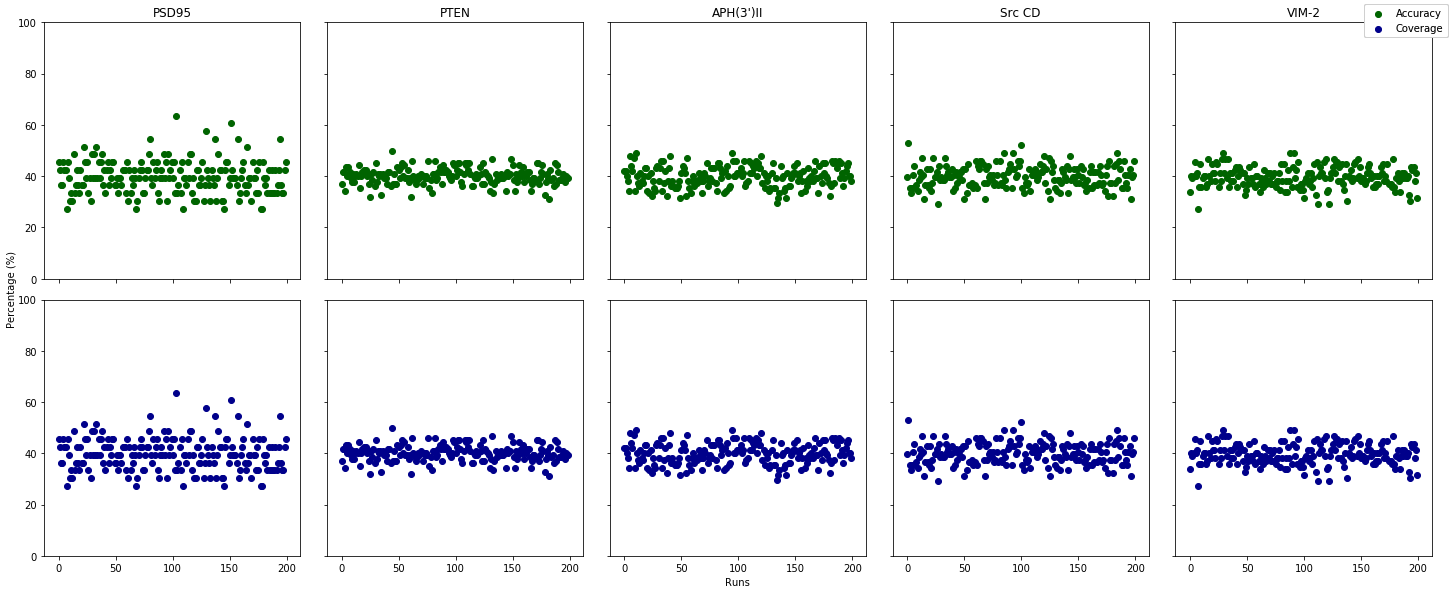

In [371]:
test = TestRandom(0.4, 0.4, 200)
test.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/nulo200r04f04p', bbox_inches='tight')

## Spearman correlations

In [239]:
def SpearmanR(protein, measure):
    '''Return list with Spearman correlation coefficient between mean functional data and mean perturbation network data
    for measure by threshold. '''
    functional_mean = list(functional_data[protein].mean())
    correlations = []
    for threshold in thresholds:
        network_data = ReadNetworkCSV(protein, threshold, measure)
        network_mean = list(network_data.mean())
        correlations.append(round(sp.stats.spearmanr(functional_mean, network_mean)[0], 3))
    return correlations

In [244]:
correlations = dict()
for measure in measures:
    for protein in proteins:
        correlations[(protein, measure)] = SpearmanR(protein, measure)

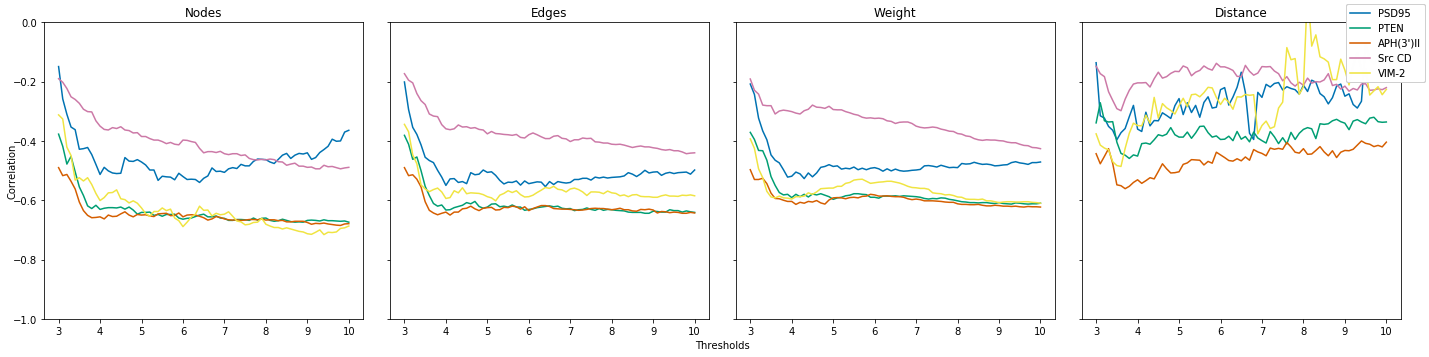

In [248]:
labels1 = ['Nodes', 'Edges', 'Weight', 'Distance']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.tight_layout()
plt.ylabel('Correlation')
plt.xlabel('Thresholds')

for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_ylim(-1,0)
    for j,protein in enumerate(proteins):
        ax.plot(thresholds, correlations[(protein, measure)], label=protein_names[j])
    ax.set_title(labels1[i])
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)

fig.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/correlations', bbox_inches='tight')

## Predictions for individual measures

In [249]:
def NetworkExtremesOneMeasure(protein, measure, cutoff, threshold):
    """ Return set with positions that have mutations that pass measure cutoff. """
    network_extremes_list = []
    network_df = Standardize(protein, threshold, measure)
    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
    return set(extremes)

In [299]:
def PredictionsOneMeasure(measure, cutoff, save=False):
    """Loss of function predictions based only on one measure, to find best threshold per measure."""
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tight_layout()
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Thresholds')
    
    for i, protein in enumerate(proteins):
        predictions, how_many = dict(), dict()
        funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])

        for threshold in thresholds:
            # positions predicted
            predictions[threshold] = NetworkExtremesOneMeasure(protein, measure, cutoff, threshold)
            # positions in intersection between predictions and funct_extremes 
            how_many[threshold] = predictions[threshold].intersection(funct_extremes)
            
        accuracy = [ToPercentage(how_many[threshold], predictions[threshold],
                                                     string=False) for threshold in thresholds] 
        coverage = [ToPercentage(how_many[threshold], funct_extremes, string=False) for threshold in thresholds] 
        
        ax = axes[i]
        ax.set_xlim(3,10)
        ax.set_ylim(0,100)
        ax.plot(thresholds, accuracy, color='darkgreen', marker='o', markeredgewidth=0.0, linewidth=0,
                 label='Accuracy')
        ax.plot(thresholds, coverage, color='darkblue', marker='o', markeredgewidth=0.0, linewidth=0,
                 label='Coverage')
        ax.set_title(protein_names[i])
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

    if save:
        cutoff1 = 1 if cutoff == 1 else 15
        fig.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/{measure}{cutoff1}')
    return fig

nodes 1


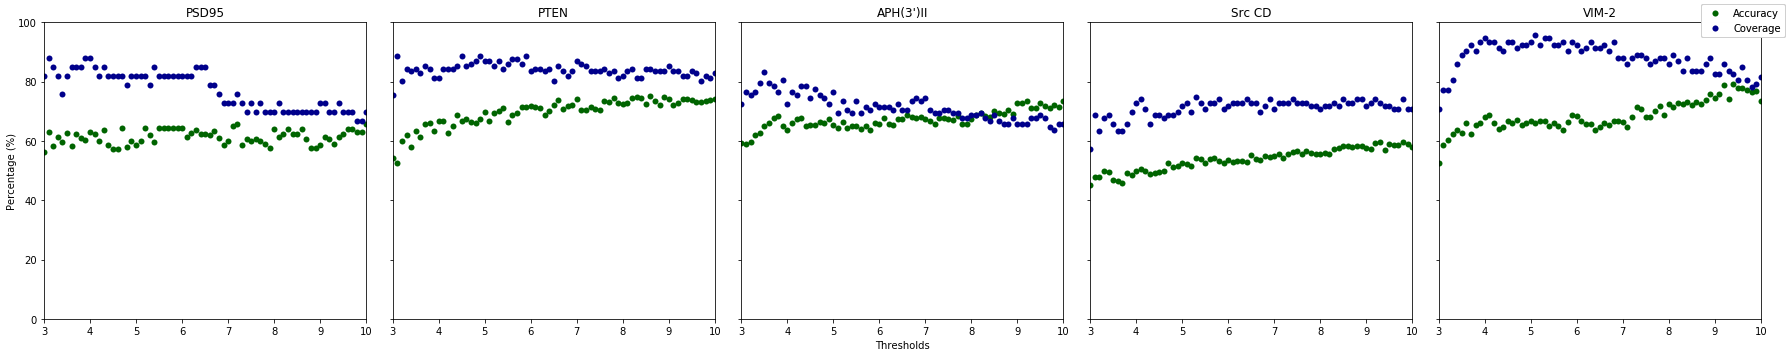

nodes 1.5


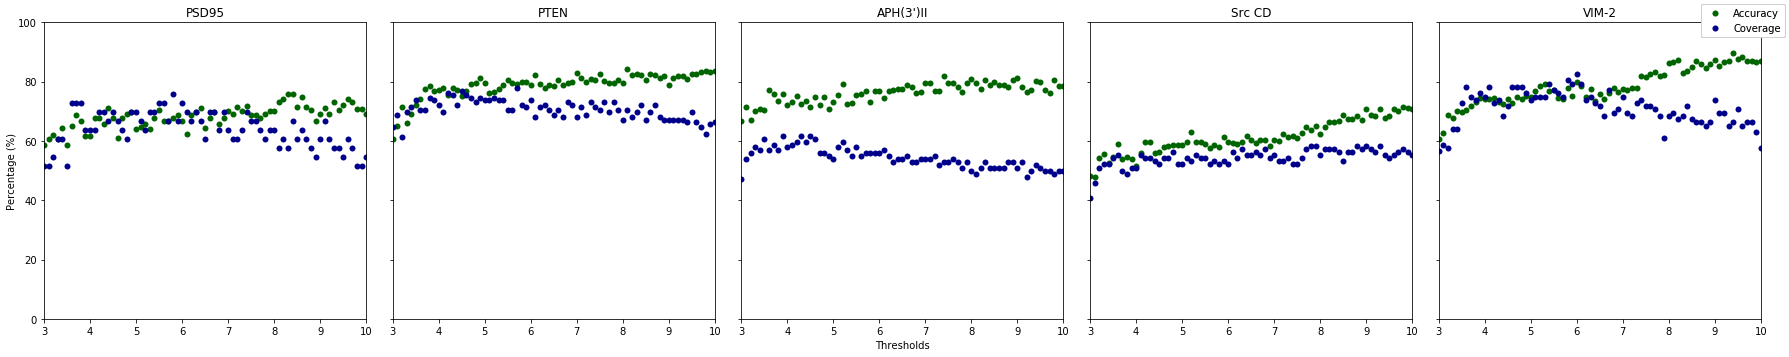

edges 1


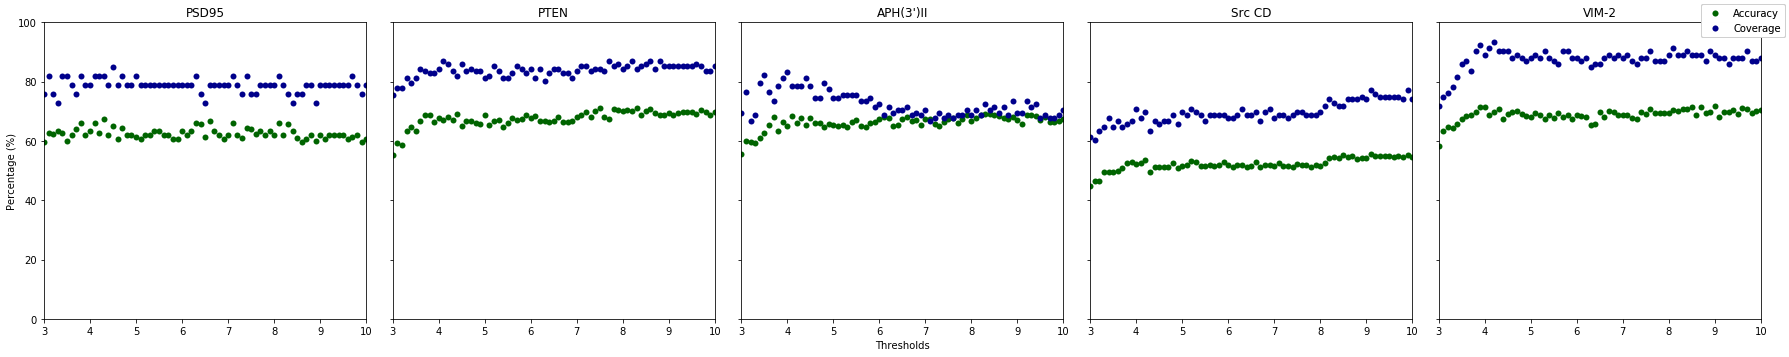

edges 1.5


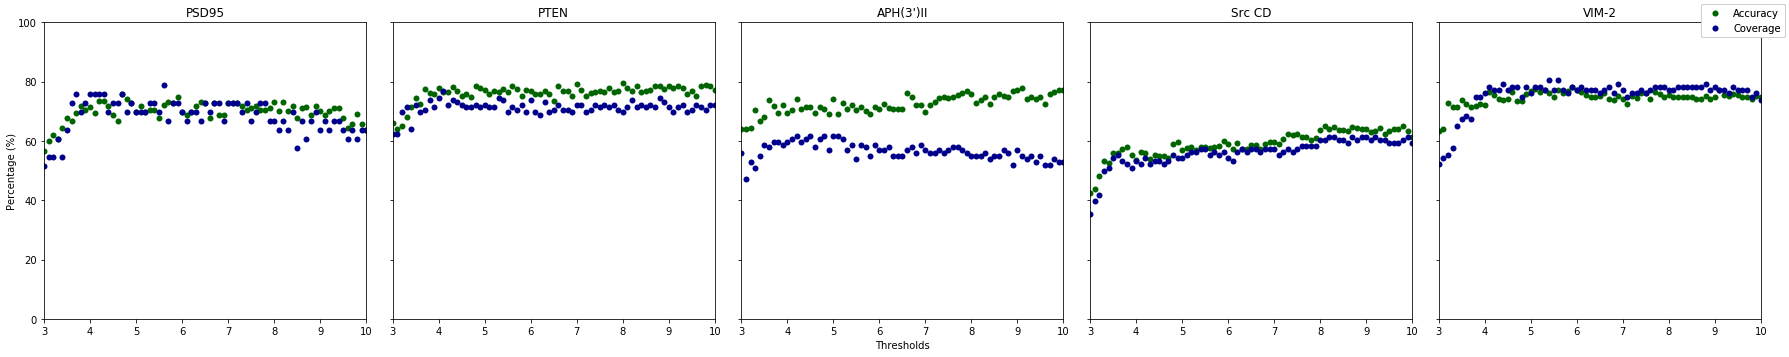

weight 1


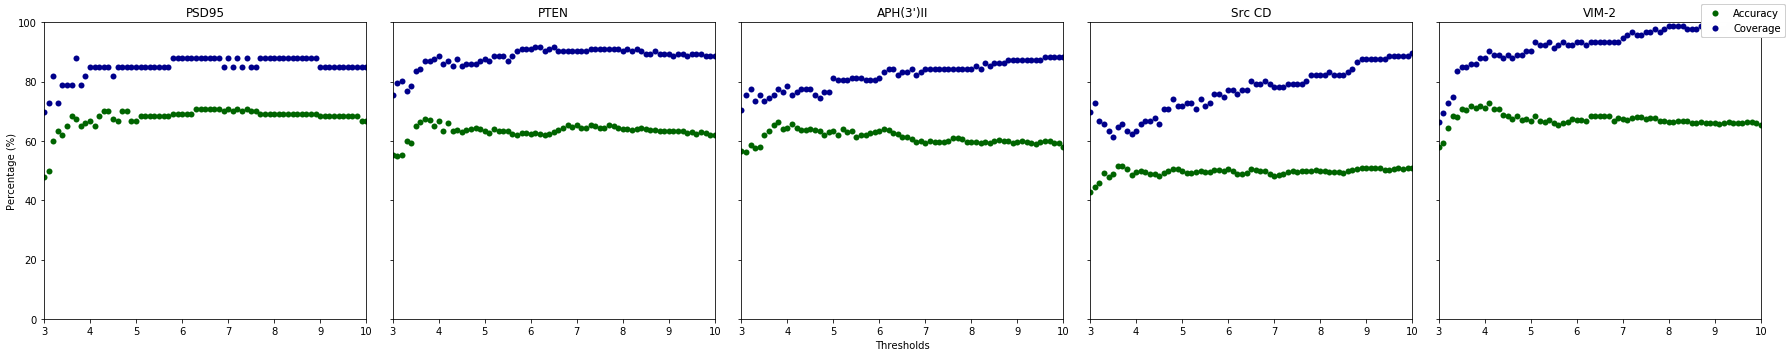

weight 1.5


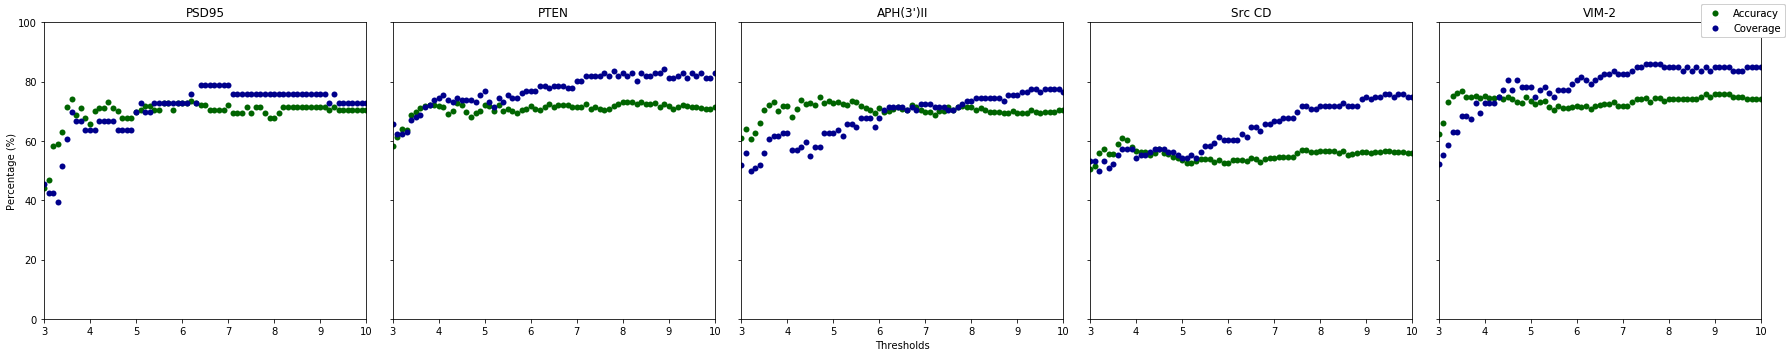

distance 1


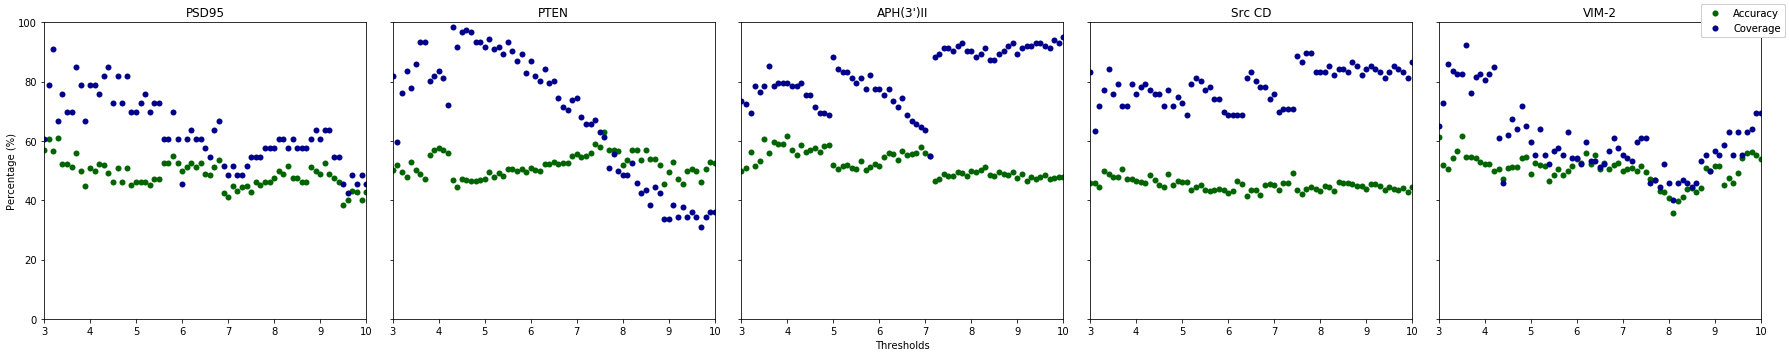

distance 1.5


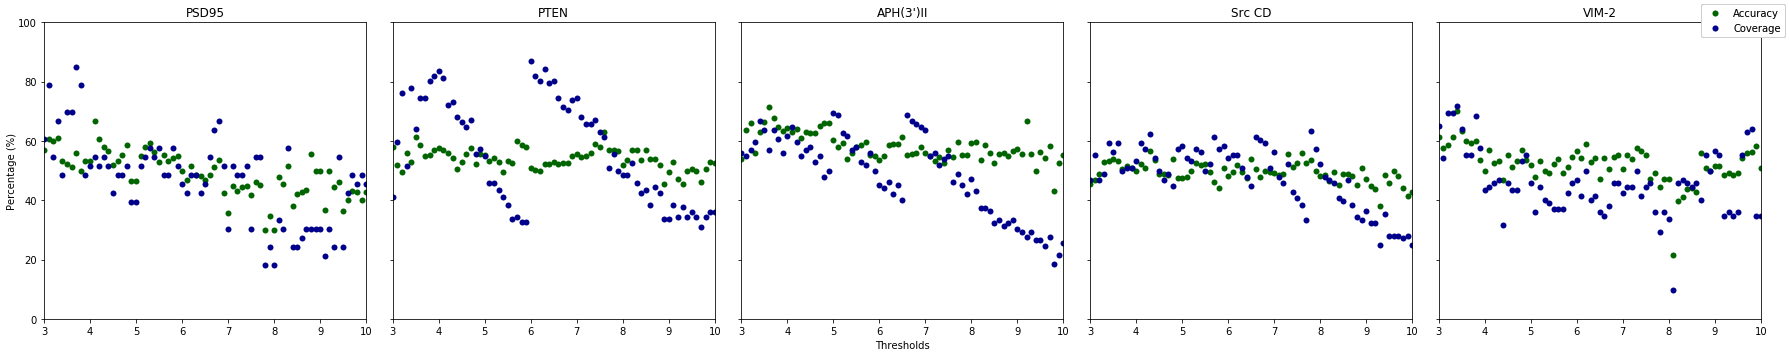

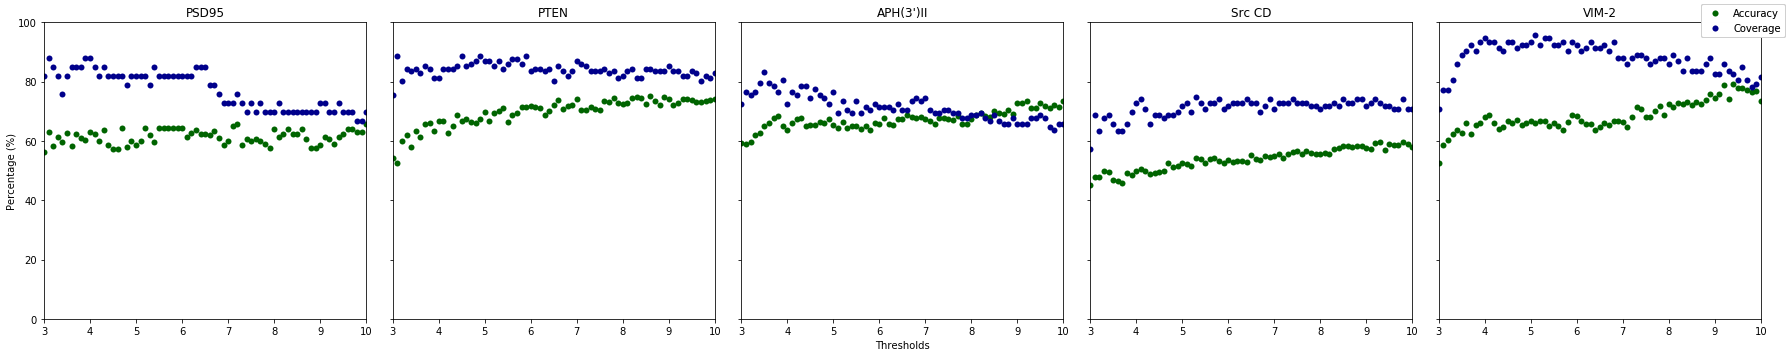

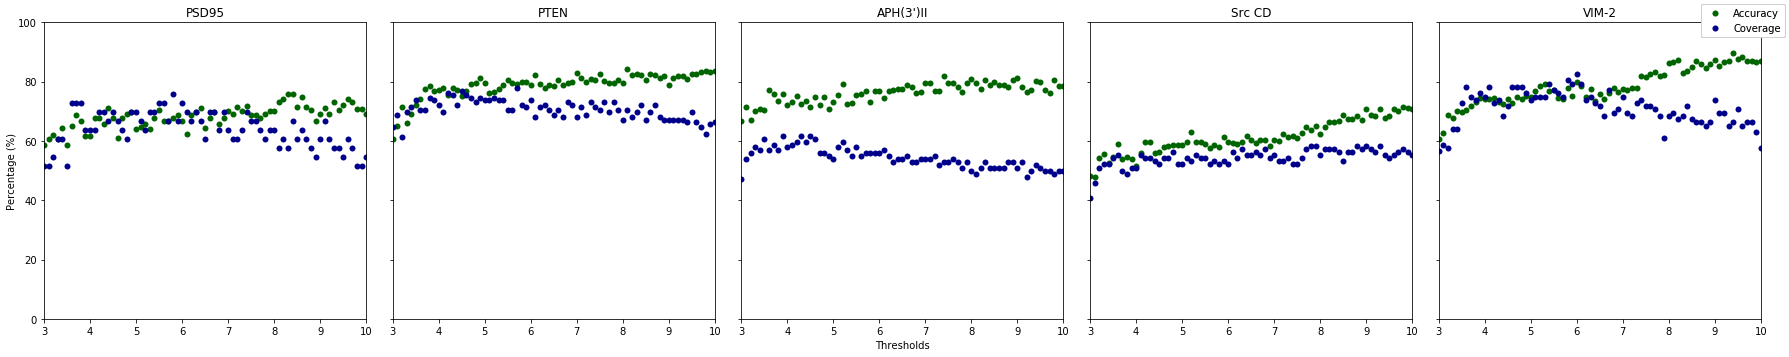

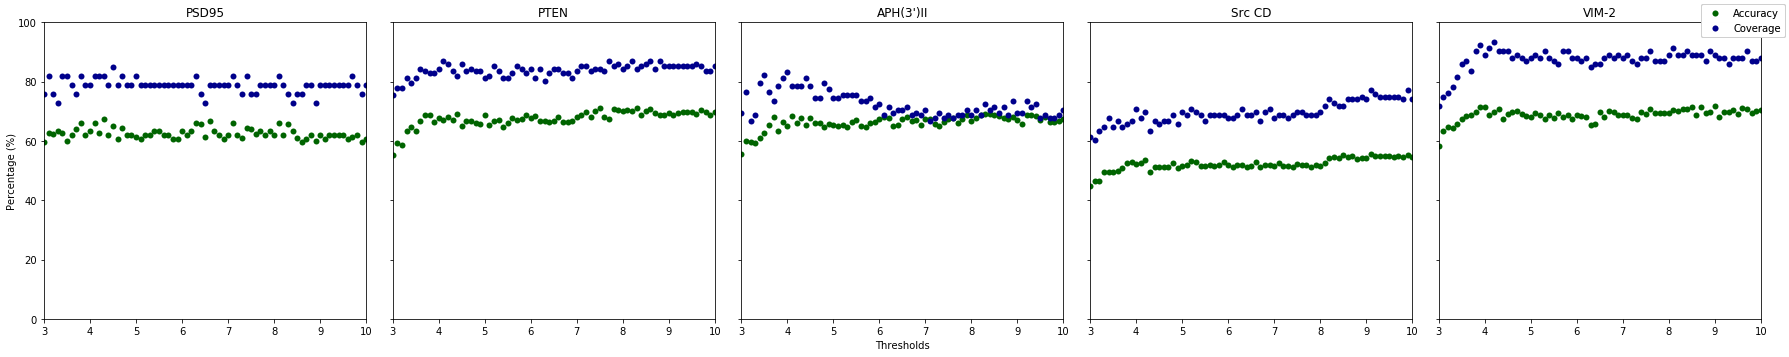

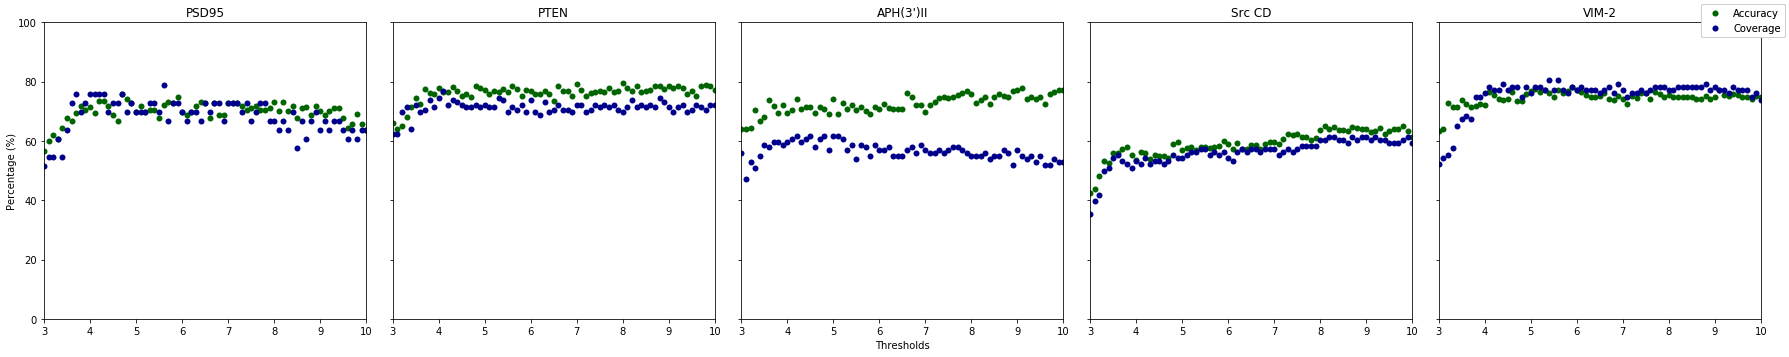

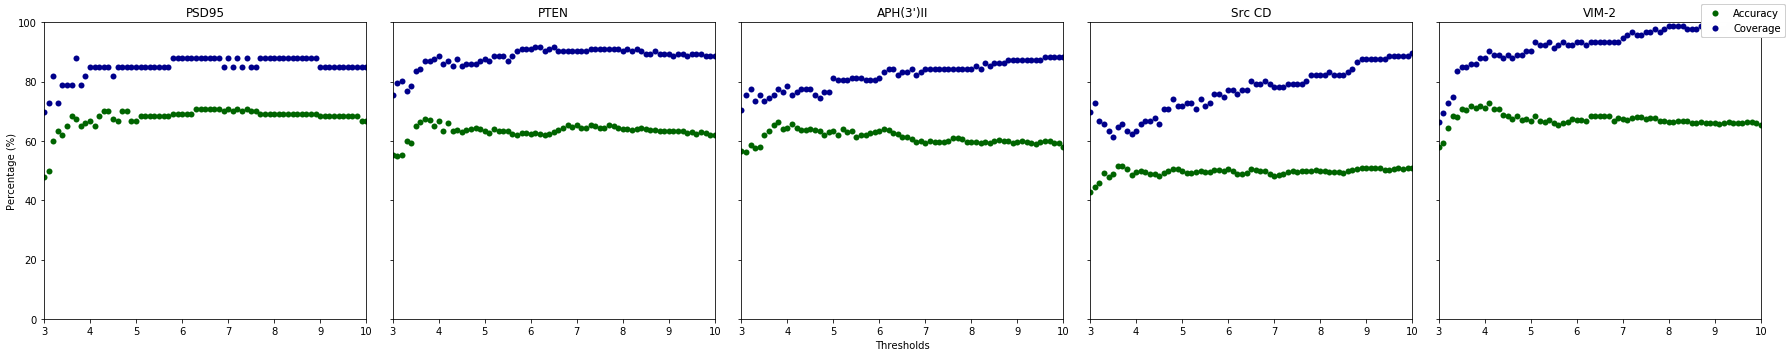

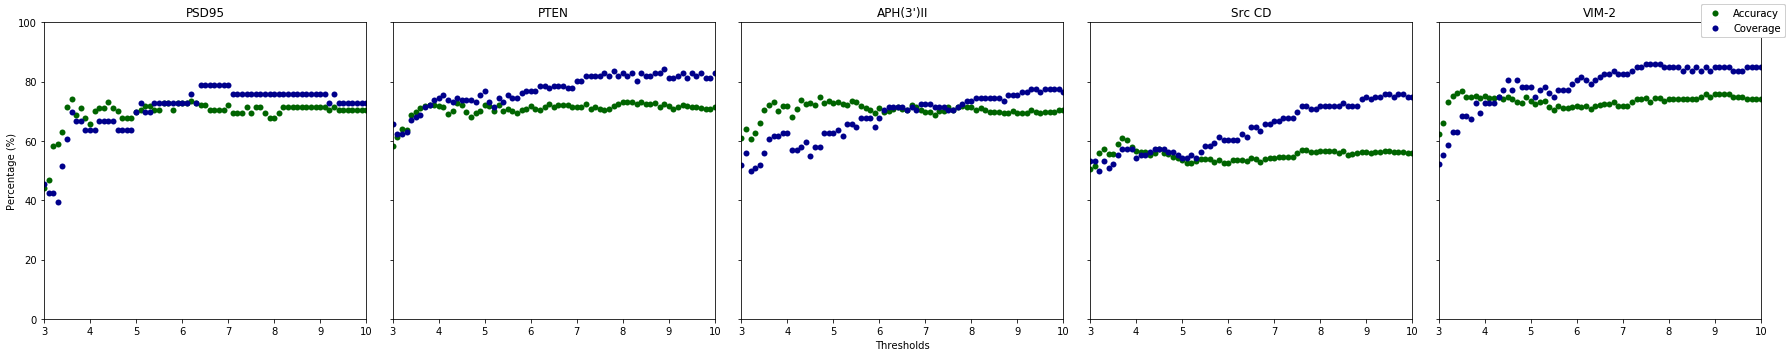

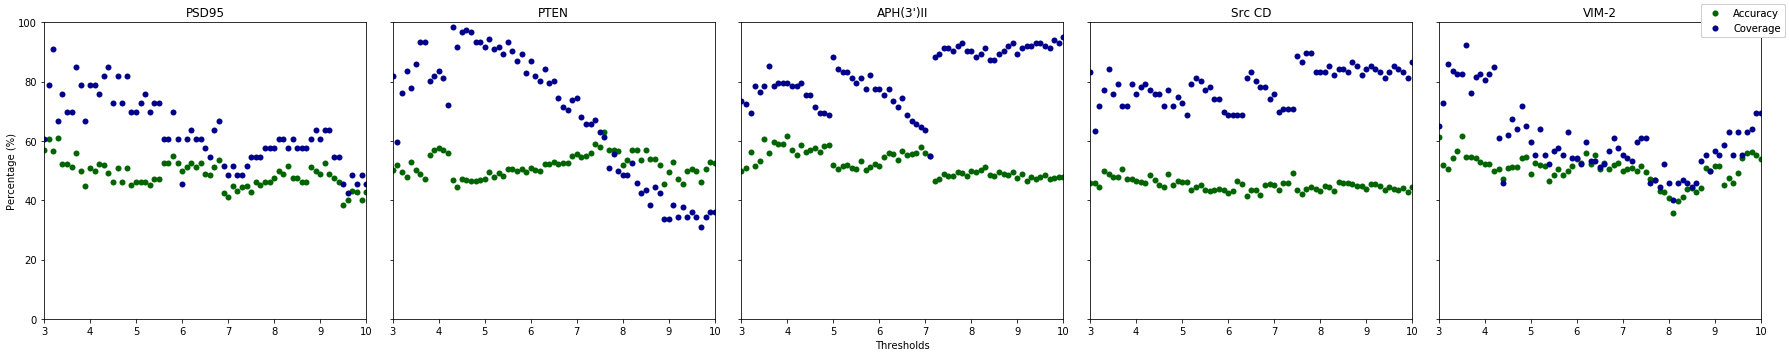

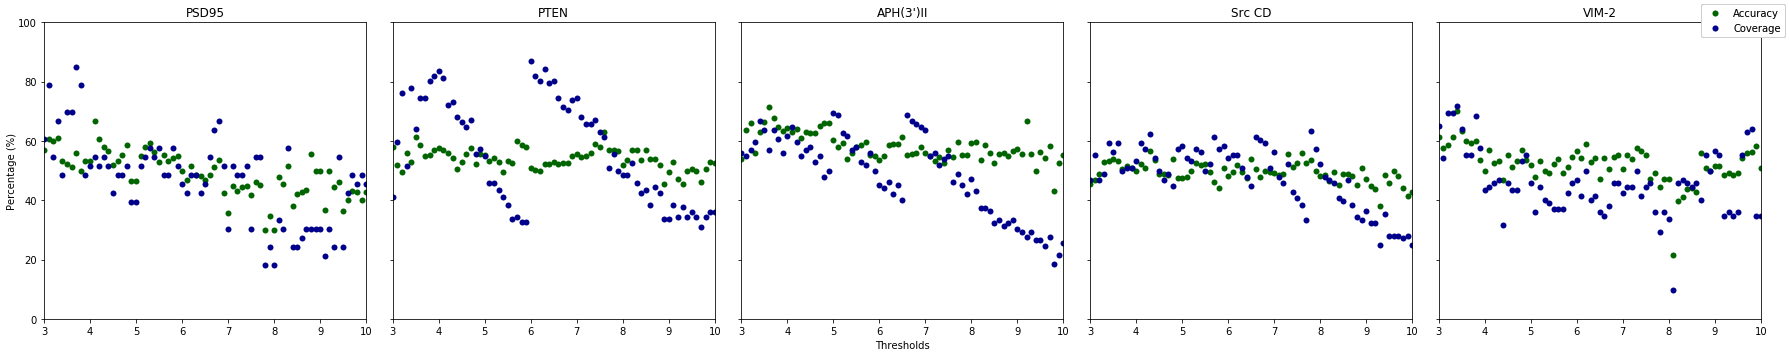

In [306]:
for measure in measures:
    for cutoff in [1, 1.5]:
        print(measure, cutoff)
        display(PredictionsOneMeasure(measure, cutoff, save=True))

### Comparing perturbation cutoffs with accuracy and coverage scores

In [341]:
def CompareAC(functional_cutoff, network_mincount, thresh=9.0, save=False):
    """Compare Accuracy and Coverage scores for range of measure cutoffs, considering same cutoff for all four 
    measures, ranging from 1 to 2. Considering loss of function predictions. """
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5), sharex=True, sharey=True)
    plt.tight_layout()
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Cutoffs')
    
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    for i, protein in enumerate(proteins):
        funct_extremes = GetPercentage(functional_cutoff, 'lowest', functional_data[protein])
        accuracy, coverage = [], []
        for cutoff in cutoffs:
            measure_cutoffs = [cutoff]*4
            network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs=measure_cutoffs, 
                                                  thresh=thresh)
            how_many = network_extremes.intersection(funct_extremes)
            accuracy.append(ToPercentage(how_many, network_extremes, string=False))
            coverage.append(ToPercentage(how_many, funct_extremes, string=False))
            
        ax = axes[i]
        ax.set_xlim(1,2)
        ax.set_ylim(0,100)
        ax.plot(cutoffs, accuracy, color='darkgreen', marker='o', markeredgewidth=0.0, linewidth=0,
                 label='Accuracy')
        ax.plot(cutoffs, coverage, color='darkblue', marker='o', markeredgewidth=0.0, linewidth=0,
                 label='Coverage')
        ax.set_title(protein_names[i])
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

    if save:
        fig.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/ \
                                                compare_mc{network_mincount}', bbox_inches='tight')
    return fig

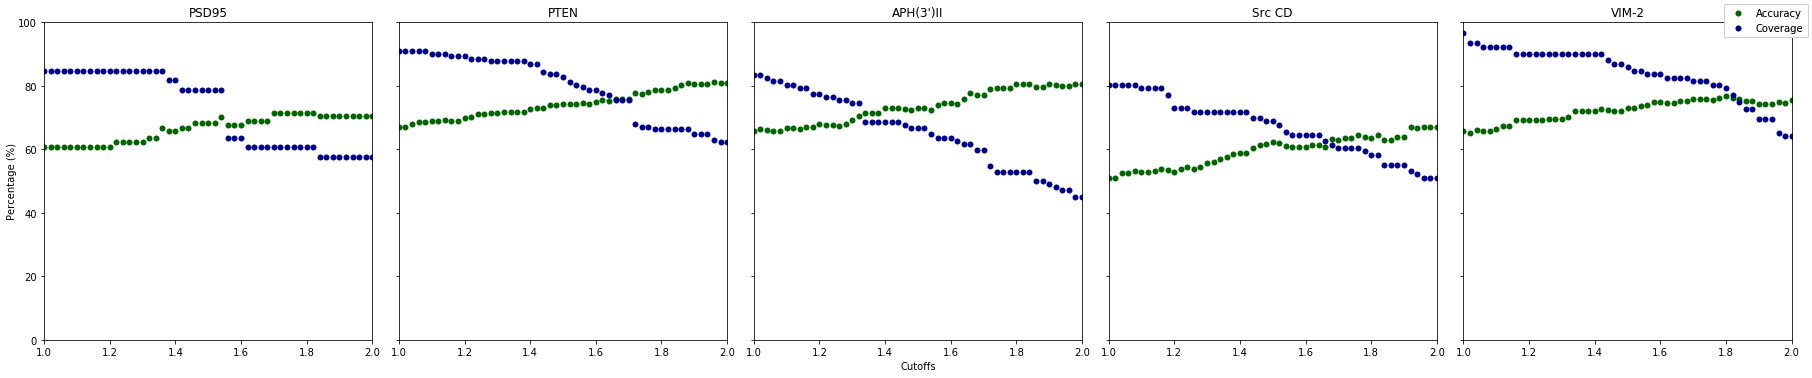

In [342]:
compare = CompareAC(0.4, 2, save=True)

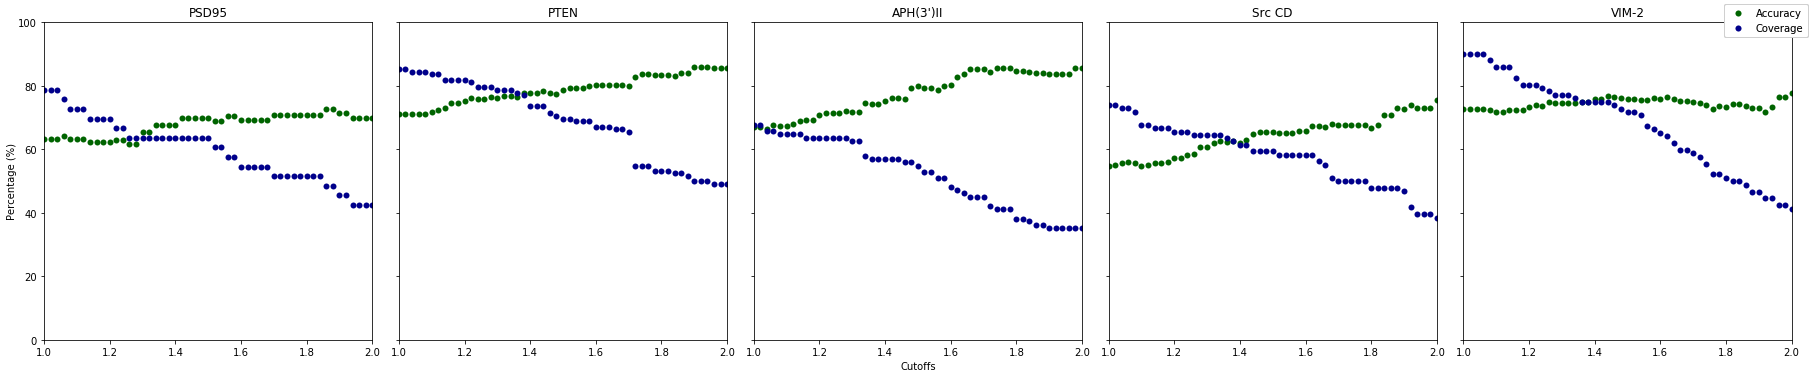

In [304]:
compare = CompareAC(0.4, 3)

### Comparing accuracy and coverage with position percentages

In [369]:
def ScoresAndPredictions():
    """Compare Accuracy scores with functional percentage, leaving parameters fixed at [1,1,1,1] and mincount of 2; 
    and Coverage scores with prediction percentage, leaving functional percentage fixed at 40%, mincount fixed at 2,
    and varying the functional cutoffs from 1 to 2. Considering loss of function predictions. """
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5), sharey=True)
    plt.tight_layout()
    
    fig.add_subplot(121, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Percentage of FSPs')

    fig.add_subplot(122, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Percentage of positions predicted')
    
    # Accuracy and functional percentage
    percentage_range = [round(i,2) for i in np.linspace(0.3, 0.7, 41)]
    ax = axes[0]
    for i, protein in enumerate(proteins):
        accuracy = []
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
        for percentage in percentage_range:
            funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
            how_many = funct_extremes.intersection(network_extremes)
            accuracy.append(ToPercentage(how_many, network_extremes, string=False))
        ax.set_ylim(0,100)
        ax.scatter(range(30,71), accuracy, label=protein_names[i])
        ax.set_ylabel('Accuracy (%)')
        
    # Coverage and functional percentage
    ax = axes[1]
    for i, protein in enumerate(proteins):
        coverage = []
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
        for percentage in percentage_range:
            funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
            how_many = funct_extremes.intersection(network_extremes)
            coverage.append(ToPercentage(how_many, funct_extremes, string=False))
        ax.set_ylim(0,100)
        ax.scatter(range(30,71), coverage, label=protein_names[i])
        ax.set_ylabel('Coverage (%)')
        
    # Accuracy and prediction percentage    
    cutoffs = [round(i,2) for i in np.linspace(1,2,81)]
    ax = axes[2]
    for i, protein in enumerate(proteins):
        accuracy = []
        n = len(functional_data[protein].columns)
        prediction_percentage = []
        funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
        for cutoff in cutoffs:
            network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*4)
            how_many = funct_extremes.intersection(network_extremes)
            prediction_percentage.append(ToPercentage(network_extremes, n, string=False))
            accuracy.append(ToPercentage(how_many, network_extremes, string=False))
        ax.set_ylim(0,100)
        ax.scatter(prediction_percentage, accuracy, label=protein_names[i])
        ax.set_ylabel('Accuracy (%)')
        
    # Coverage and prediction percentage
    ax = axes[3]
    for i, protein in enumerate(proteins):
        coverage = []
        n = len(functional_data[protein].columns)
        prediction_percentage = []
        funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
        for cutoff in cutoffs:
            network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*4)
            how_many = funct_extremes.intersection(network_extremes)
            prediction_percentage.append(ToPercentage(network_extremes, n, string=False))
            coverage.append(ToPercentage(how_many, funct_extremes, string=False))
        ax.set_ylim(0,100)
        ax.scatter(prediction_percentage, coverage, label=protein_names[i])
        ax.set_ylabel('Coverage (%)')    
        
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)
    return fig

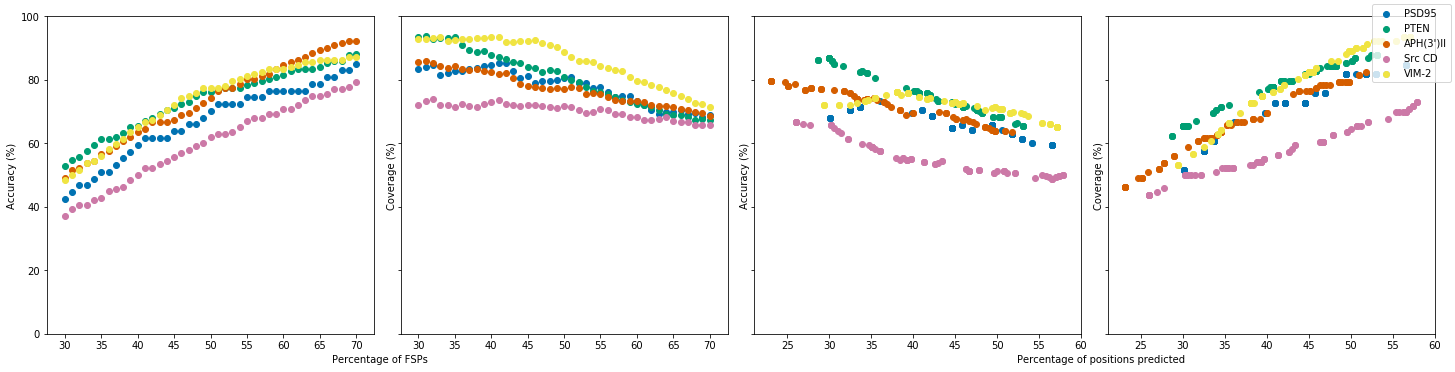

In [370]:
fig = ScoresAndPredictions()
fig.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/scorespercentages', bbox_inches='tight')

### Loss of function predictions

In [35]:
def ComparePredictionsLoss(functional_percentage, network_mincount, measure_cutoffs=[1,1,1,1], thresh=9.0):
    """Compare percentage of positions with highest mean functional values with predicted positions above cutoff for 
    perturbation network data. Return True Positives, False Positives, Coverage, Accuracy, and percentages of 
    positions. 
    
    Parameters:
        functional_percentage (float): Percentage of positions with lowest mean scores to compare to. 
        network_mincount (int): Minimum number of measures for which a position needs to pass cutoff to be predicted 
                              functionally sensitive. Int between 1 and 4, inclusive. 
        measure_cutoffs (list, 4 ints): Standard deviations above average that determine predictions for each measure.
                                        In order, [nodes, edges, weight, distance].
        thresh (float): threshold to be used for perturbation scores for nodes, edges and weight. Thresh for distance 
                        is always 3.8.
    Returns:
        DataFrame with True and False Positives, Coverage, Accuracy, Prediction % and Functional %
    """
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        funct_extremes = GetPercentage(functional_percentage, 'lowest', functional_data[protein])
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    return predict 

In [36]:
# Predictions maximizing coverage
ComparePredictionsLoss(0.4, 2, measure_cutoffs=[1,1,1,1])

,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,28,18,84.8%,60.9%,55.4%,39.8%
1d5r,111,55,91.0%,66.9%,54.1%,39.7%
1nd4,85,44,83.3%,65.9%,50.6%,40.0%
3dqw,77,74,80.2%,51.0%,62.4%,39.7%
4bz3,89,46,96.7%,65.9%,58.4%,39.8%


In [25]:
# Predictions maximizing accuracy
ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5])

,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,14,7,42.4%,66.7%,25.3%,39.8%
1d5r,68,13,55.7%,84.0%,26.4%,39.7%
1nd4,38,4,37.3%,90.5%,16.5%,40.0%
3dqw,37,14,38.5%,72.5%,21.1%,39.7%
4bz3,49,5,53.3%,90.7%,23.4%,39.8%


In [26]:
# Predictions maximizing both
ComparePredictionsLoss(0.4, 2, measure_cutoffs=[1.5,1.5,1.5,1.5])

,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,26,12,78.8%,68.4%,45.8%,39.8%
1d5r,101,35,82.8%,74.3%,44.3%,39.7%
1nd4,68,25,66.7%,73.1%,36.5%,40.0%
3dqw,66,40,68.8%,62.3%,43.8%,39.7%
4bz3,79,29,85.9%,73.1%,46.8%,39.8%


### Functional robustness predictions

In [28]:
def ComparePredictionsGain(functional_percentage, network_mincount, measure_cutoffs=[1,1,1,1], thresh=9.0):
    """Compare percentage of positions with highest mean functional values with complement of predicted positions for 
    loss of function for given measure_cutoffs and mincounts. Return True Positives, False Positives, Coverage, 
    Accuracy, and percentages of positions. 
    
    Parameters:
        functional_percentage (float): Percentage of positions with highes mean scores to compare to. 
        network_mincount (int): Minimum number of measures for which a position needs to pass cutoff to be predicted 
                              functionally sensitive. Int between 1 and 4, inclusive. 
        measure_cutoffs (list, 4 ints): Standard deviations above average that determine predictions for each measure.
                                        In order, [nodes, edges, weight, distance].
        thresh (float): threshold to be used for perturbation scores for nodes, edges and weight. Thresh for distance 
                        is always 3.8.
    Returns:
        DataFrame with True and False Positives, Coverage, Accuracy, Prediction % and Functional %
    """
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        total_positions = functional_data[protein].columns
        funct_extremes = GetPercentage(functional_percentage, 'highest', functional_data[protein])
        network_extremes = set([pos for pos in total_positions if pos not in network_extremes_loss])
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    return predict 

In [29]:
# Predictions maximizing accuracy
ComparePredictionsGain(0.4, 1, measure_cutoffs=[1,1,1,1])

,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,18,7,54.5%,72.0%,30.1%,39.8%
1d5r,61,29,50.0%,67.8%,29.3%,39.7%
1nd4,59,19,57.8%,75.6%,30.6%,40.0%
3dqw,38,21,39.6%,64.4%,24.4%,39.7%
4bz3,49,13,53.3%,79.0%,26.8%,39.8%


In [30]:
# Predictions maximizing coverage
ComparePredictionsGain(0.4, 3, measure_cutoffs=[1,1,1,1])

,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,23,19,69.7%,54.8%,50.6%,39.8%
1d5r,98,63,80.3%,60.9%,52.4%,39.7%
1nd4,91,61,89.2%,59.9%,59.6%,40.0%
3dqw,63,49,65.6%,56.2%,46.3%,39.7%
4bz3,79,38,85.9%,67.5%,50.6%,39.8%


In [31]:
# Predictions maximizing both
ComparePredictionsGain(0.4, 2, measure_cutoffs=[1,1,1,1])

,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,23,14,69.7%,62.2%,44.6%,39.8%
1d5r,90,51,73.8%,63.8%,45.9%,39.7%
1nd4,86,40,84.3%,68.3%,49.4%,40.0%
3dqw,53,38,55.2%,58.2%,37.6%,39.7%
4bz3,69,27,75.0%,71.9%,41.6%,39.8%


## Predictions summary

In [37]:
headers = ['Maximizing Accuracy', 'Maximizing Coverage', 'Both']
scores = ['Accuracy', 'Coverage', 'Prediction %']
index = pd.MultiIndex.from_product([headers, scores], names=['Prediction', 'Score'])

In [38]:
loss_predictions = pd.DataFrame(index=protein_names, columns=index)

In [54]:
accuracy = ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5])
coverage = ComparePredictionsLoss(0.4, 2,measure_cutoffs=[1,1,1,1])
both = ComparePredictionsLoss(0.4, 2, measure_cutoffs=[1.5,1.5,1.5,1.5])
best_loss = [accuracy, coverage, both]

for j,prediction in enumerate(headers):
    for i, protein in enumerate(protein_names):
        for score in scores:
            loss_predictions.at[protein, (prediction, score)] = best_loss[j].at[proteins[i], score]

for prediction in headers:
    for score in scores:
        total = 0
        for protein in protein_names:
            total += float(loss_predictions.at[protein, (prediction, score)][:-1])
        loss_predictions.at['Mean', (prediction, score)] = ToPercentage(total,500)

In [55]:
# Summary of loss predictions 
display(loss_predictions)

Prediction Maximizing Accuracy                       Maximizing Coverage  \
Score                 Accuracy Coverage Prediction %            Accuracy   
PSD95                    66.7%    42.4%        25.3%               60.9%   
PTEN                     84.0%    55.7%        26.4%               66.9%   
APH(3')II                90.5%    37.3%        16.5%               65.9%   
Src CD                   72.5%    38.5%        21.1%               51.0%   
VIM-2                    90.7%    53.3%        23.4%               65.9%   
Mean                     80.9%    45.4%        22.5%               62.1%   

Prediction                           Both                        
Score      Coverage Prediction % Accuracy Coverage Prediction %  
PSD95         84.8%        55.4%    68.4%    78.8%        45.8%  
PTEN          91.0%        54.1%    74.3%    82.8%        44.3%  
APH(3')II     83.3%        50.6%    73.1%    66.7%        36.5%  
Src CD        80.2%        62.4%    62.3%    68.8%        43.8%  
VIM-2         96.7%        58.4%    73.1%    85.9%        46.8%  
Mean          87.2%        56.2%    70.2%    76.6%        43.4%

In [49]:
gain_predictions = pd.DataFrame(index=protein_names, columns=index)

In [58]:
accuracy = ComparePredictionsGain(0.4, 1, measure_cutoffs=[1,1,1,1])
coverage = ComparePredictionsGain(0.4, 3,measure_cutoffs=[1,1,1,1])
both = ComparePredictionsGain(0.4, 2, measure_cutoffs=[1,1,1,1])
best_gain = [accuracy, coverage, both]

for j,prediction in enumerate(headers):
    for i, protein in enumerate(protein_names):
        for score in scores:
            gain_predictions.at[protein, (prediction, score)] = best_gain[j].at[proteins[i], score]

for prediction in headers:
    for score in scores:
        total = 0
        for protein in protein_names:
            total += float(gain_predictions.at[protein, (prediction, score)][:-1])
        gain_predictions.at['Mean', (prediction, score)] = ToPercentage(total,500)

In [59]:
# Summary of robustness predictions
display(gain_predictions)

Prediction Maximizing Accuracy                       Maximizing Coverage  \
Score                 Accuracy Coverage Prediction %            Accuracy   
PSD95                    72.0%    54.5%        30.1%               54.8%   
PTEN                     67.8%    50.0%        29.3%               60.9%   
APH(3')II                75.6%    57.8%        30.6%               59.9%   
Src CD                   64.4%    39.6%        24.4%               56.2%   
VIM-2                    79.0%    53.3%        26.8%               67.5%   
Mean                     71.8%    51.0%        28.2%               59.9%   

Prediction                           Both                        
Score      Coverage Prediction % Accuracy Coverage Prediction %  
PSD95         69.7%        50.6%    62.2%    69.7%        44.6%  
PTEN          80.3%        52.4%    63.8%    73.8%        45.9%  
APH(3')II     89.2%        59.6%    68.3%    84.3%        49.4%  
Src CD        65.6%        46.3%    58.2%    55.2%        37.6%  
VIM-2         85.9%        50.6%    71.9%    75.0%        41.6%  
Mean          78.1%        51.9%    64.9%    71.6%        43.8%

### Prediction summary figures

In [81]:
def GraphPredictionPercentages(predictions):
    '''Show prediction percentages by protein and mean, based on loss_predictions or gain_predictions.'''
    labels1 = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2', 'Mean']

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=True)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Percentage (%)")

    for i, prediction in enumerate(headers):
        ax = axes[i]
        ax.set_ylim(0,100)

        percentages = dict()
        for score in scores:
            percentages[score] = [float(x[:-1]) for x in predictions[(prediction, score)]]

        x = np.arange(len(labels1))  
        width = 0.2 

        accuracy = ax.bar(x - 3*width/2, percentages['Accuracy'], width, label='Accuracy', edgecolor='none', 
                          color='darkgreen')
        functperc = ax.bar(x - width/2, [40]*6, width, label='FSP %', edgecolor='none', color='limegreen')
        coverage = ax.bar(x + width/2, percentages['Coverage'], width, label='Coverage', edgecolor='none', 
                          color='darkblue')
        predperc = ax.bar(x + 3*width/2, percentages['Prediction %'], width, label='Prediction %', edgecolor='none', 
                          color='deepskyblue')

        ax.set_title(prediction)
        ax.set_xticks(x)
        ax.set_xticklabels(labels1, rotation=90)

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

    return fig

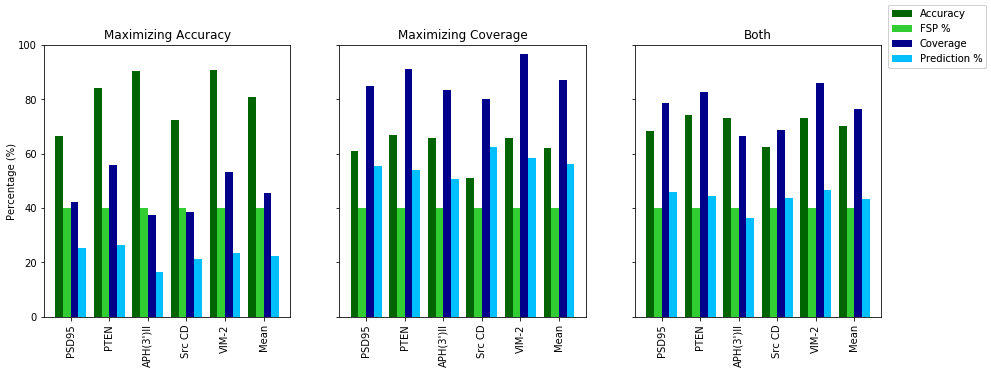

In [88]:
# Loss predictions
loss = GraphPredictionPercentages(loss_predictions)
#loss.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/losspredictions', bbox_inches='tight')

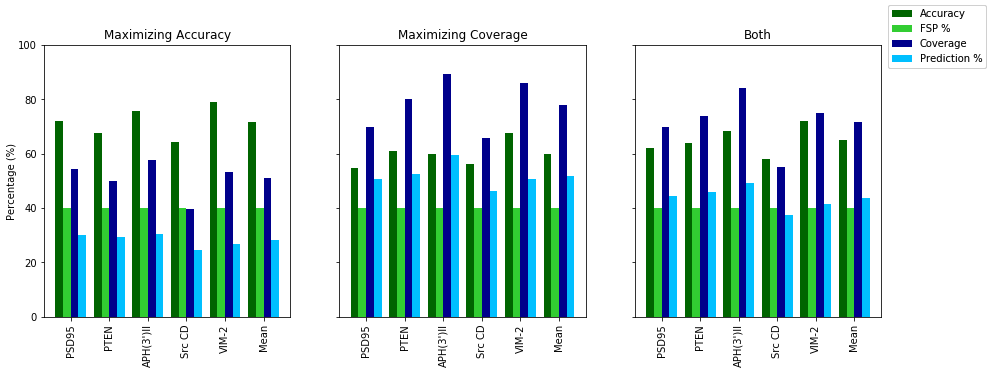

In [106]:
# Robustness predictions
gain = GraphPredictionPercentages(gain_predictions)
#gain.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/gainpredictions', bbox_inches='tight')

## Comparing predictions with functional values

### Loss predictions

In [168]:
def GraphLossPredictions(functional_percentage, network_mincount, measure_cutoffs=[1,1,1,1], thresh=9.0):
    '''Graph positions and mean functional value, marking predictions for loss of function and where functional 
    percentage separates values.'''
    labels1 = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5))
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Mean Functional Value')
    plt.xlabel('Positions')

    for i, protein in enumerate(proteins):
        ax = axes[i]
        mean = functional_data[protein].mean()
        positions = functional_data[protein].columns
        n = len(positions)
        predictions = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh)
        
        # values to plot, depending on whether they are predicted or not
        predicted_values = [mean[pos] for pos in positions if pos in predictions]
        predicted_indices = [i for i,pos in enumerate(positions) if pos in predictions]
        other_values = [mean[pos] for pos in positions if pos not in predictions]
        other_indices = [i for i,pos in enumerate(positions) if pos not in predictions]
        
        ax.plot(predicted_indices, predicted_values, color='orange', marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions predicted')
        ax.plot(other_indices, other_values, color='deepskyblue', marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions not predicted')

        # mark functional percentage
        mean_list = list(mean)
        mean_list.sort()
        m = mean_list[int(n*0.4)]
        ax.plot([i for i in range(n)], [m for i in range(n)], 
                                        label=f'Bottom {int(100*functional_percentage)}% of values')

        ax.set_title(protein_names[i])
        
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

    return fig

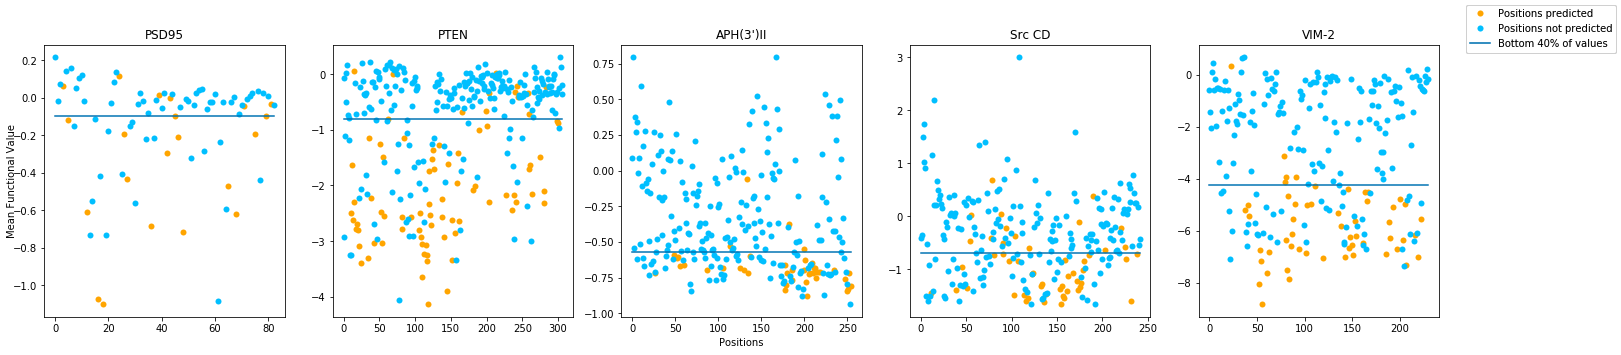

In [169]:
# Loss predictions maximizing accuracy
accuracy = GraphLossPredictions(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5])
#accuracy.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/accuracy', bbox_inches='tight')

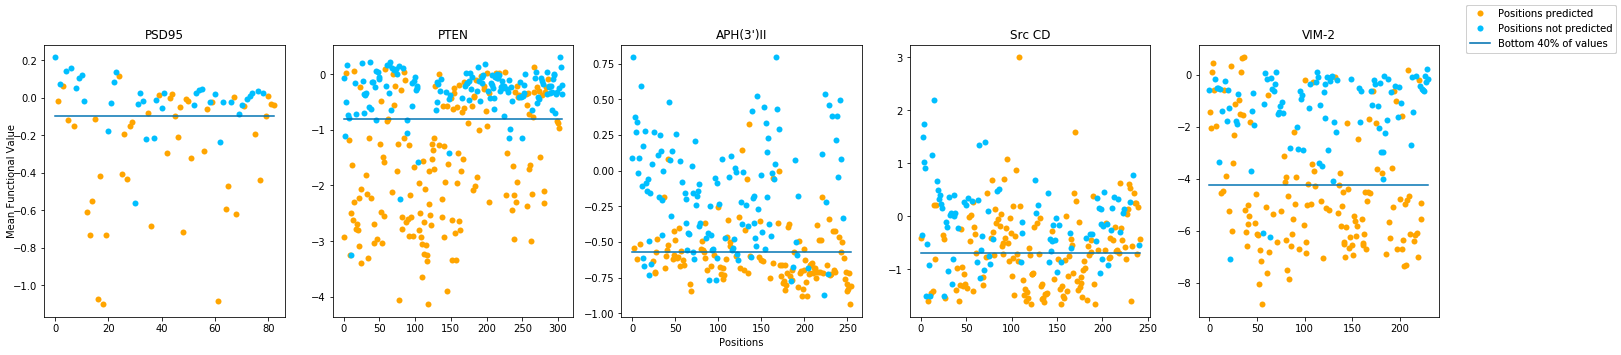

In [166]:
# Loss predictions maximizing coverage
coverage = GraphLossPredictions(0.4, 2, measure_cutoffs=[1,1,1,1])
#coverage.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/coverage', bbox_inches='tight')

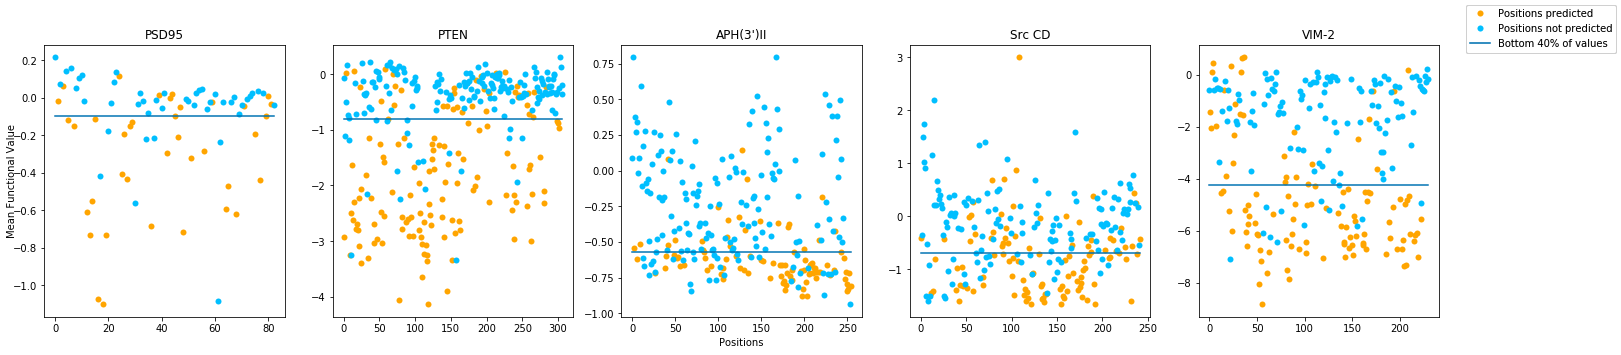

In [167]:
# Loss predictions maximizing both measures
both = GraphLossPredictions(0.4, 2, measure_cutoffs=[1.5,1.5,1.5,1.5])
#both.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/both', bbox_inches='tight')

### Robustness predictions

In [173]:
def GraphGainPredictions(functional_percentage, network_mincount, measure_cutoffs=[1,1,1,1], thresh=9.0):
    '''Graph positions and mean functional value, marking predictions for robust positions and where functional 
    percentage separates values.'''
    labels1 = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5))
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Mean Functional Value')
    plt.xlabel('Positions')

    for i, protein in enumerate(proteins):
        ax = axes[i]
        mean = functional_data[protein].mean()
        positions = functional_data[protein].columns
        n = len(positions)
        predictions_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh)
        predictions = set([pos for pos in positions if pos not in predictions_loss])
        
        # values to plot, depending on whether they are predicted or not
        predicted_values = [mean[pos] for pos in positions if pos in predictions]
        predicted_indices = [i for i,pos in enumerate(positions) if pos in predictions]
        other_values = [mean[pos] for pos in positions if pos not in predictions]
        other_indices = [i for i,pos in enumerate(positions) if pos not in predictions]
        
        ax.plot(predicted_indices, predicted_values, color='orange', marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions predicted')
        ax.plot(other_indices, other_values, color='deepskyblue', marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions not predicted')

        # mark functional percentage
        mean_list = list(mean)
        mean_list.sort(reverse=True)
        m = mean_list[int(n*0.4)]
        ax.plot([i for i in range(n)], [m for i in range(n)], 
                                        label=f'Top {int(100*functional_percentage)}% of values')

        ax.set_title(protein_names[i])
        
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

    return fig

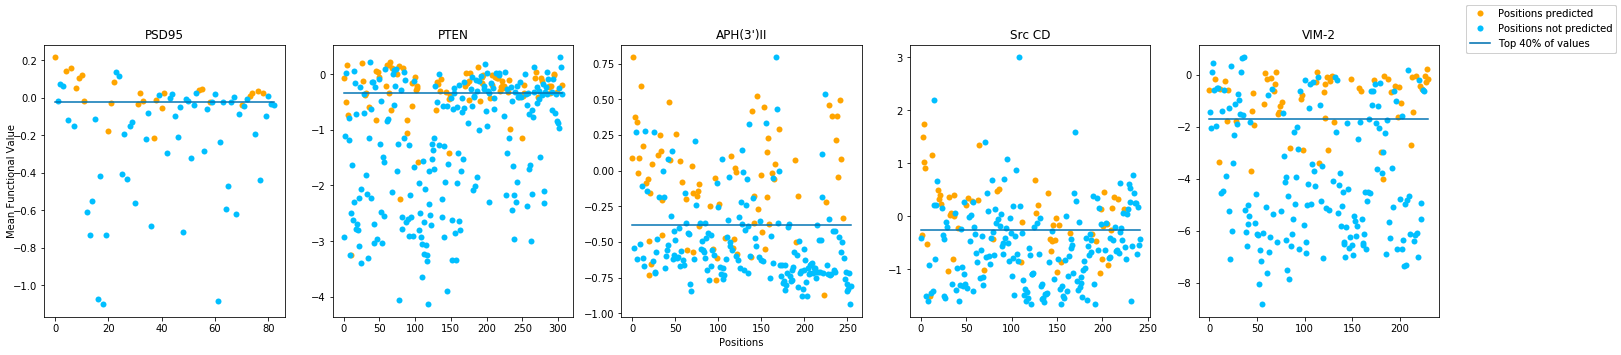

In [175]:
# Robustness predictions maximizing accuracy
accuracy = GraphGainPredictions(0.4, 1, measure_cutoffs=[1,1,1,1])
#accuracy.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/accuracy_gain', bbox_inches='tight')

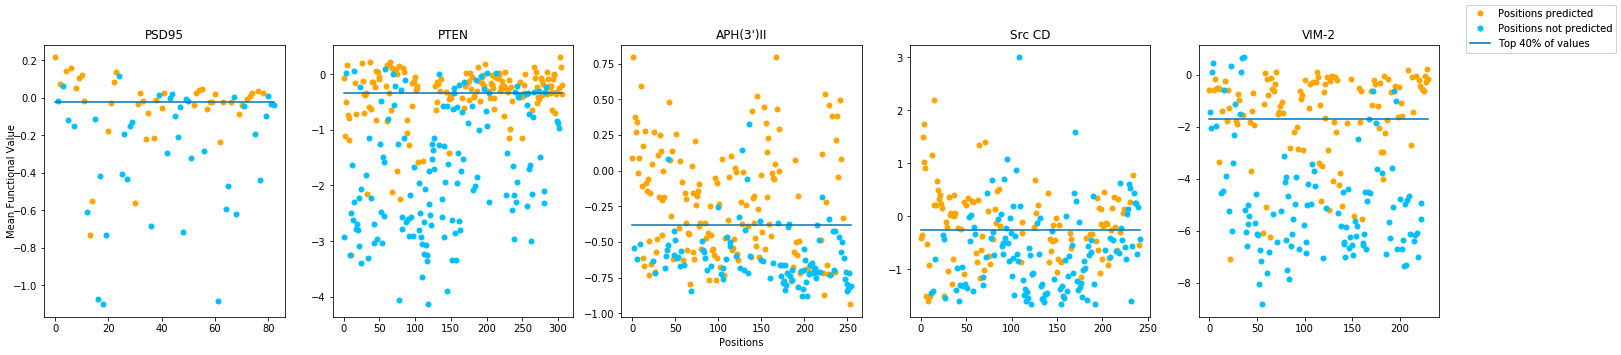

In [176]:
# Robustness predictions maximizing coverage
coverage = GraphGainPredictions(0.4, 3, measure_cutoffs=[1,1,1,1])
coverage.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/coverage_gain', bbox_inches='tight')

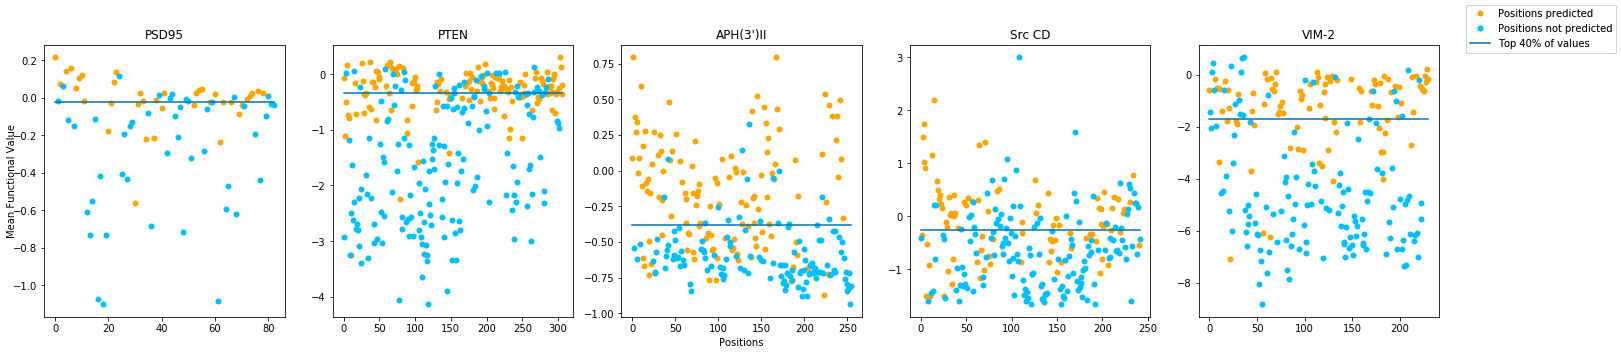

In [177]:
# Robustness predictions maximizing both measures
both = GraphGainPredictions(0.4, 2, measure_cutoffs=[1,1,1,1])
both.savefig(f'/Users/macbook/Dropbox/perturbation_networks/draft/figures/both_gain', bbox_inches='tight')